In [98]:
from rpy2 import robjects

r_yM = robjects.r(
    """
    library(sn)
    Sigma <- matrix(c(1, 0.4, 0.4, 0.6), 2, 2)
    m <- c(0, -1)
    gamma1 <- c(0, -0.6)
    cpM <- list(mean=m, var.cov=Sigma, gamma1=gamma1)
    dpM <- cp2dp(cpM, family="SN")
    print("Direct Parameters: ")
    print(dpM)

    x <- c(0.5, 0.0)

    print("PDF: ")
    print(dmsn(x, dp=dpM))
    print("Log PDF: ")
    print(dmsn(x, dp=dpM, log=TRUE))
    
    yM <- rmsn(1000, dp=dpM)
    yM
    """
)

[1] "Direct Parameters: "
$beta
[1]  0.000000 -0.133893

$Omega
     [,1]     [,2]
[1,]  1.0 0.400000
[2,]  0.4 1.350141

$alpha
[1]   3.660546 -10.633482

attr(,"delta.star")
[1] 0.9950209
[1] "PDF: "
[1] 0.1869563
[1] "Log PDF: "
[1] -1.67688


In [93]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from soundscapy.spi.multivariate_skewnorm_commit import multivariate_skewnormal


# Define parameters (DP)
xi = np.array([0.0, -0.133893])  # Location
Omega = np.array([[1.0, 0.4], [0.4, 1.350141]])  # Scale matrix
alpha = np.array([3.660546, -10.633482])  # Shape vector

# Create a frozen instance of the distribution
msn_frozen = multivariate_skewnormal(loc=xi, cov=Omega, skew=alpha)

# Generate random samples
n_samples = 1000
py_yM = msn_frozen.rvs(n_samples)


# Point(s) to evaluate
x_point = np.array([0.5, 0.0])
# x_multiple = np.array([[0.5, 0.0], [0.3, -0.5], [-0.2, 0.2]])

# Using the frozen instance
pdf_val = msn_frozen.pdf(x_point)
logpdf_val = msn_frozen.logpdf(x_point)
# cdf_val = msn_frozen.cdf(x_point)  # CDF calculation can be slow
# logcdf_val = msn_frozen.logcdf(x_point)

print(f"--- Evaluation at {x_point} ---")
print(f"PDF: {pdf_val:.5f}")
print(f"logPDF: {logpdf_val:.5f}")
# print(f"CDF: {cdf_val:.5f}")
# print(f"logCDF: {logcdf_val:.5f}")


--- Evaluation at [0.5 0. ] ---
PDF: 0.62465
logPDF: -0.47057


/Users/mitch/Documents/GitHub/Soundscapy/src/soundscapy/spi/multivariate_skewnorm_commit.py:1099: DeprecationWarning: Bitwise inversion '~' on bool is deprecated. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  if ~cor:


In [68]:
# Code créé par Gabriel Taillon le 7 Mai 2018
# From https://github.com/Gabinou/2DKS
#  Kolmogorov-Smyrnov Test extended to two dimensions.
# References:s
#  [1] Peacock, J. A. (1983). Two-dimensional goodness-of-fit testing
#  in astronomy. Monthly Notices of the Royal Astronomical Society,
#  202(3), 615-627.
#  [2] Fasano, G., & Franceschini, A. (1987). A multidimensional version of
#  the Kolmogorov–Smirnov test. Monthly Notices of the Royal Astronomical
#  Society, 225(1), 155-170.
#  [3] Flannery, B. P., Press, W. H., Teukolsky, S. A., & Vetterling, W.
#  (1992). Numerical recipes in C. Press Syndicate of the University
#  of Cambridge, New York, 24, 78.
import inspect

import numpy as np
import scipy.stats


def CountQuads(Arr2D, point):
    """Computes the probabilities of finding points in each 4 quadrant
    defined by a vertical and horizontal lines crossing the point, by counting
    the proportion of points in Arr2D in each quadrant.

    :param list Arr2D: Array of points to be counted.
    :param array point: A 2 element list, point, which is the center of
    4 square quadrants.
    :returns: a tuple of 4 floats.  The probabilities of finding a point in
    each quadrants, with point as the origin.  p stands for positive, n for
    negative, with the first and second positions meaning the x and y
    directions respectively.
    """
    if isinstance(point, list):
        point = np.asarray((np.ravel(point)))
    elif type(point).__module__ + type(point).__name__ == "numpyndarray":
        point = np.ravel(point.copy())
    else:
        raise TypeError("Input point is neither list nor numpyndarray")
    if len(point) != 2:
        return
    if isinstance(Arr2D, list):
        Arr2D = np.asarray((Arr2D))
    elif type(Arr2D).__module__ + type(Arr2D).__name__ == "numpyndarray":
        pass
    else:
        raise TypeError("Input Arr2D is neither list nor numpyndarray")
    if Arr2D.shape[1] > Arr2D.shape[0]:  # Reshape to A[row,column]
        Arr2D = Arr2D.copy().T
    if Arr2D.shape[1] != 2:
        raise TypeError("Input Arr2D is not 2D")
    # The pp of Qpp refer to p for 'positive' and n for 'negative' quadrants.
    # In order. first subscript is x, second is y.
    Qpp = Arr2D[(Arr2D[:, 0] > point[0]) & (Arr2D[:, 1] > point[1]), :]
    Qnp = Arr2D[(Arr2D[:, 0] < point[0]) & (Arr2D[:, 1] > point[1]), :]
    Qpn = Arr2D[(Arr2D[:, 0] > point[0]) & (Arr2D[:, 1] < point[1]), :]
    Qnn = Arr2D[(Arr2D[:, 0] < point[0]) & (Arr2D[:, 1] < point[1]), :]
    # Normalized fractions:
    ff = 1.0 / len(Arr2D)
    fpp = len(Qpp) * ff
    fnp = len(Qnp) * ff
    fpn = len(Qpn) * ff
    fnn = len(Qnn) * ff
    # NOTE:  all the f's are supposed to sum to 1.0. Float representation
    # cause SOMETIMES sum to 1.000000002 or something. I don't know how to
    # test for that reliably, OR what to do about it yet. Keep in mind.
    return (fpp, fnp, fpn, fnn)


def FuncQuads(func2D, point, xlim, ylim, rounddig=4):
    """Computes the probabilities of finding points in each 4 quadrant
    defined by a vertical and horizontal lines crossing the point, by
    integrating the density function func2D in each quadrant.

    :param array func2D: Density function that takes 2 arguments: x and y.
    :param list point: A 2 element list, point, which is the center of 4
    square quadrants.
    :param array xlim,ylim: Domain of numerical integration necessary to
    compute the quadrant probabilities.
    :returns: a tuple of 4 floats. The probabilities of finding a point in
    each quadrants, with point as the origin.  p stands for positive,
    n for negative, with the first and second positions meaning the x and y
    directions respectively.
    """
    if callable(func2D):
        if len(inspect.getfullargspec(func2D)[0]) != 2:
            raise TypeError("Input func2D is not a function with 2 arguments")
        pass
    else:
        raise TypeError("Input func2D is not a function")
    # If xlim, ylim and point are not lists or ndarray, exit.
    if isinstance(point, list):
        point = np.asarray((np.ravel(point)))
    elif type(point).__module__ + type(point).__name__ == "numpyndarray":
        point = np.ravel(point.copy())
    else:
        raise TypeError("Input point is not a list or numpyndarray")
    if len(point) != 2:
        raise TypeError("Input point has not exactly 2 elements")
    if isinstance(xlim, list):
        xlim = np.asarray((np.sort(np.ravel(xlim))))
    elif type(xlim).__module__ + type(xlim).__name__ == "numpyndarray":
        xlim = np.sort(np.ravel(xlim.copy()))
    else:
        raise TypeError("Input xlim is not a list or ndarray")
    if len(xlim) != 2:
        raise TypeError("Input xlim has not exactly 2 elements")
    if xlim[0] == xlim[1]:
        raise TypeError("Input xlim[0] should be different to xlim[1]")
    if isinstance(ylim, list):
        ylim = np.asarray((np.sort(np.ravel(ylim))))
    elif type(ylim).__module__ + type(ylim).__name__ == "numpyndarray":
        ylim = np.sort(np.ravel(ylim.copy()))
    else:
        raise TypeError("Input ylim is not a list or ndarray")
    if len(ylim) != 2:
        raise TypeError("Input ylim has not exactly 2 elements")
    if ylim[0] == ylim[1]:
        raise TypeError("Input ylim[0] should be different to ylim[1]")
    # Numerical integration to find the quadrant probabilities.
    totInt = scipy.integrate.dblquad(
        func2D, *xlim, lambda x: np.amin(ylim), lambda x: np.amax(ylim)
    )[0]
    Qpp = scipy.integrate.dblquad(
        func2D, point[0], np.amax(xlim), lambda x: point[1], lambda x: np.amax(ylim)
    )[0]
    Qpn = scipy.integrate.dblquad(
        func2D, point[0], np.amax(xlim), lambda x: np.amin(ylim), lambda x: point[1]
    )[0]
    Qnp = scipy.integrate.dblquad(
        func2D, np.amin(xlim), point[0], lambda x: point[1], lambda x: np.amax(ylim)
    )[0]
    Qnn = scipy.integrate.dblquad(
        func2D, np.amin(xlim), point[0], lambda x: np.amin(ylim), lambda x: point[1]
    )[0]
    fpp = round(Qpp / totInt, rounddig)
    fnp = round(Qnp / totInt, rounddig)
    fpn = round(Qpn / totInt, rounddig)
    fnn = round(Qnn / totInt, rounddig)
    return (fpp, fnp, fpn, fnn)


def Qks(alam, iter=100, prec=1e-17):
    """Computes the value of the KS probability function, as a function of
    alam, the D statistic. From *Numerical recipes in C* page 623: '[...]
    the K–S statistic useful is that its distribution in the case of the null
    hypothesis (data sets drawn from the same distribution) can be calculated,
    at least to useful approximation, thus giving the significance of any
    observed nonzero value of D.' (D being the KS statistic).

    :param float alam: D statistic.
    :param int iter: Number of iterations to be perfomed. On non-convergence,
    returns 1.0.
    :param float prec: Convergence criteria of the qks. Stops converging if
    that precision is attained.
    :returns: a float. The significance level of the observed D statistic.
    """
    # If j iterations are performed, meaning that toadd
    # is still 2 times larger than the precision.
    if isinstance(alam, int) | isinstance(alam, float):
        pass
    else:
        raise TypeError("Input alam is neither int nor float")
    toadd = [1]
    qks = 0.0
    j = 1
    while (j < iter) & (abs(toadd[-1]) > prec * 2):
        toadd.append(2.0 * (-1.0) ** (j - 1.0) * np.exp(-2.0 * j**2.0 * alam**2.0))
        qks += toadd[-1]
        j += 1
    if (j == iter) | (qks > 1):  # If no convergence after j iter, return 1.0
        return 1.0
    if qks < prec:
        return 0.0
    else:
        return qks


def ks2d2s(Arr2D1, Arr2D2):
    """ks stands for Kolmogorov-Smirnov, 2d for 2 dimensional,
    2s for 2 samples.
    KS test for goodness-of-fit on two 2D samples. Tests the hypothesis that
    the two samples are from the same distribution.

    :param array Arr2D1: 2D array of points/samples.
    :param array Arr2D2: 2D array of points/samples.
    :returns: a tuple of two floats. First, the two-sample K-S statistic.
    If this value is higher than the significance level of the hypothesis,
    it is rejected. Second, the significance level of *d*. Small values of
    prob show that the two samples are significantly different.
    """
    if type(Arr2D1).__module__ + type(Arr2D1).__name__ == "numpyndarray":
        pass
    else:
        raise TypeError("Input Arr2D1 is neither list nor numpyndarray")
    if Arr2D1.shape[1] > Arr2D1.shape[0]:
        Arr2D1 = Arr2D1.copy().T
    if type(Arr2D2).__module__ + type(Arr2D2).__name__ == "numpyndarray":
        pass
    else:
        raise TypeError("Input Arr2D2 is neither list nor numpyndarray")
    if Arr2D2.shape[1] > Arr2D2.shape[0]:
        Arr2D2 = Arr2D2.copy().T
    if Arr2D1.shape[1] != 2:
        raise TypeError("Input Arr2D1 is not 2D")
    if Arr2D2.shape[1] != 2:
        raise TypeError("Input Arr2D2 is not 2D")
    d1, d2 = 0.0, 0.0
    for point1 in Arr2D1:
        fpp1, fmp1, fpm1, fmm1 = CountQuads(Arr2D1, point1)
        fpp2, fmp2, fpm2, fmm2 = CountQuads(Arr2D2, point1)
        d1 = max(d1, abs(fpp1 - fpp2))
        d1 = max(d1, abs(fpm1 - fpm2))
        d1 = max(d1, abs(fmp1 - fmp2))
        d1 = max(d1, abs(fmm1 - fmm2))
    for point2 in Arr2D2:
        fpp1, fmp1, fpm1, fmm1 = CountQuads(Arr2D1, point2)
        fpp2, fmp2, fpm2, fmm2 = CountQuads(Arr2D2, point2)
        d2 = max(d2, abs(fpp1 - fpp2))
        d2 = max(d2, abs(fpm1 - fpm2))
        d2 = max(d2, abs(fmp1 - fmp2))
        d2 = max(d2, abs(fmm1 - fmm2))
    d = (d1 + d2) / 2.0
    sqen = np.sqrt(len(Arr2D1) * len(Arr2D2) / (len(Arr2D1) + len(Arr2D2)))
    R1 = scipy.stats.pearsonr(Arr2D1[:, 0], Arr2D1[:, 1])[0]
    R2 = scipy.stats.pearsonr(Arr2D2[:, 0], Arr2D2[:, 1])[0]
    RR = np.sqrt(1.0 - (R1 * R1 + R2 * R2) / 2.0)
    prob = Qks(d * sqen / (1.0 + RR * (0.25 - 0.75 / sqen)))
    # Small values of prob show that the two samples are significantly
    # different. Prob is the significance level of an observed value of d.
    # NOT the same as the significance level that ou set and compare to D.
    return (d, prob)


def ks2d1s(Arr2D, func2D, xlim=[], ylim=[]):
    """ks stands for Kolmogorov-Smirnov, 2d for 2 dimensional,
    1s for 1 sample.
    KS test for goodness-of-fit on one 2D sample and one 2D density
    distribution. Tests the hypothesis that the data was generated
    from the density distribution.

    :param array Arr2D: 2D array of points/samples.
    :param func2D: Density distribution. Could implement a function for
    arrays in the future...
    :param array xlim, ylim: Defines the domain for the numerical integration
    necessary to compute the quadrant probabilities.
    :returns: tuple of two floats. First, the two-sample K-S statistic.
    If this value is higher than the significance level of the hypothesis,
    it is rejected. Second, the significance level of *d*. Small values of
    prob show that the two samples are significantly different.
    """
    if callable(func2D):
        if len(inspect.getfullargspec(func2D)[0]) != 2:
            raise TypeError("Input func2D is not a function with 2 input arguments")
        pass
    else:
        raise TypeError("Input func2D is not a function")
    if type(Arr2D).__module__ + type(Arr2D).__name__ == "numpyndarray":
        pass
    else:
        raise TypeError("Input Arr2D is neither list nor numpyndarray")
    print(Arr2D.shape)
    if Arr2D.shape[1] > Arr2D.shape[0]:
        Arr2D = Arr2D.copy().T
    if Arr2D.shape[1] != 2:
        raise TypeError("Input Arr2D is not 2D")
    if xlim == []:
        xlim.append(
            np.amin(Arr2D[:, 0]) - abs(np.amin(Arr2D[:, 0]) - np.amax(Arr2D[:, 0])) / 10
        )
        xlim.append(
            np.amax(Arr2D[:, 0]) - abs(np.amin(Arr2D[:, 0]) - np.amax(Arr2D[:, 0])) / 10
        )
    if ylim == []:
        ylim.append(
            np.amin(Arr2D[:, 1]) - abs(np.amin(Arr2D[:, 1]) - np.amax(Arr2D[:, 1])) / 10
        )

        ylim.append(
            np.amax(Arr2D[:, 1]) - abs(np.amin(Arr2D[:, 1]) - np.amax(Arr2D[:, 1])) / 10
        )
    d = 0
    for point in Arr2D:
        fpp1, fmp1, fpm1, fmm1 = FuncQuads(func2D, point, xlim, ylim)
        fpp2, fmp2, fpm2, fmm2 = CountQuads(Arr2D, point)
        d = max(d, abs(fpp1 - fpp2))
        d = max(d, abs(fpm1 - fpm2))
        d = max(d, abs(fmp1 - fmp2))
        d = max(d, abs(fmm1 - fmm2))
    sqen = np.sqrt(len(Arr2D))
    R1 = scipy.stats.pearsonr(Arr2D[:, 0], Arr2D[:, 1])[0]
    RR = np.sqrt(1.0 - R1**2)
    prob = Qks(d * sqen / (1.0 + RR * (0.25 - 0.75 / sqen)))
    return d, prob


In [69]:
ks2d2s(r_yM, py_yM)

(0.0835, 0.014313441084397853)

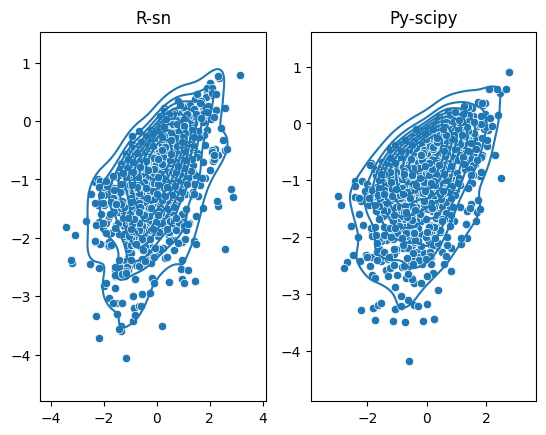

In [70]:
fig, axes = plt.subplots(1, 2)
sns.kdeplot(x=r_yM[:, 0], y=r_yM[:, 1], ax=axes[0])
sns.kdeplot(x=py_yM[:, 0], y=py_yM[:, 1], ax=axes[1])

sns.scatterplot(x=r_yM[:, 0], y=r_yM[:, 1], ax=axes[0])
sns.scatterplot(x=py_yM[:, 0], y=py_yM[:, 1], ax=axes[1])

axes[0].set_title("R-sn")
axes[1].set_title("Py-scipy")
plt.show()

In [ ]:
# Point(s) to evaluate
x_point = np.array([0.5, 0.0])
x_multiple = np.array([[0.5, 0.0], [0.3, -0.5], [-0.2, 0.2]])

# Using the frozen instance
pdf_val = msn_frozen.pdf(x_point)
logpdf_val = msn_frozen.logpdf(x_point)
cdf_val = msn_frozen.cdf(x_point)  # CDF calculation can be slow
logcdf_val = msn_frozen.logcdf(x_point)

print(f"--- Evaluation at {x_point} ---")
print(f"PDF: {pdf_val:.5f}")
print(f"logPDF: {logpdf_val:.5f}")
print(f"CDF: {cdf_val:.5f}")
print(f"logCDF: {logcdf_val:.5f}")

# Using the generator directly with parameters
pdf_multi = multivariate_skewnormal.pdf(x_multiple, loc=xi, cov=Omega, skew=alpha)
print("\n--- PDF Evaluation at multiple points ---")
print(pdf_multi)
